# PCA

## 0. 简介

PCA（principal component analysis）即主成分分析，是一种无监督学习方法。其目标是找到原空间中的__低维子空间__，或是其正交基。PCA同时求原数据点在该低维子空间中的投影，以及将该投影重新映射回原空间。

对于给定的居中化数据$\{X_i\}_{i=1}^n$与低维子空间的（标准）正交基W，我们希望原数据点投影后尽量保持在原空间中的信息，即数据点尽量离散，__方差之和取得最大__。即求解以下优化目标：

$$
arg\max_W \sum_{i=1}^n \frac{1}{n-1}||W^Tx_i||_2^2
$$

即

$$
arg\max_W \frac{1}{n-1}W^TXX^TW
$$

其中$\frac{1}{n-1}XX^T$即为数据集X的协方差矩阵。该矩阵对角线上为每个维度的方差，其他位置为不同维度间的协方差。应用拉格朗日乘子法可知W为此__协方差矩阵的特征向量__组成的矩阵时可取得目标函数的最大值。为了压缩数据，W仅取对应特征值前k大的特征向量，即W的大小为$d\times{k}$，其中d为原空间维度，而k为目标低维子空间维度。

使用最小投影距离也可得到相同的目标函数。对于维度较高而样本量较少的数据集（即d很大但n较小），如人脸数据集等图像数据，计算大小为$d\times{d}$的协方差矩阵的特征向量是极为耗时的，然而计算大小为$n\times{n}$的内积矩阵，即$X^TX$就容易很多。SVD（singular value decomposition，奇异值分解）即可用__内积矩阵的特征值__完成数据的降维，而将低维子空间中的数据点映回原空间则仍需要求解协方差矩阵的特征向量。

## 1. PCA的实现

__实验环境__: Red Hat 6.4, Python 3.6.5 (Anaconda), Jupyter

### 1.1 PCA的算法流程

该实现使用了两种方法：__EVD（特征值分解）__与__SVD（奇异值分解）__。后一种仅将数据点映射到低维子空间，而不求解子空间的（标准正交）基或其重新向原空间的映射。使用EVD的PCA算法流程为：

1. 求每一维度上数据集的均值，并减去这一均值，使得数据居中化；
2. 求该输入矩阵的协方差矩阵，即$\frac{1}{n-1}XX^T$；
3. 求协方差矩阵的特征值；
4. 将特征向量按特征值大小排序，并取前k个，k即目标低维子空间的维度；
5. 将特征向量组成的矩阵记为U。标准化U，此即低维子空间的标准正交基。$U^TX$即为数据点在子空间上的投影；
6. $UU^TX$为低维投影在原空间上的映射，并加上步骤1中所得均值以复原。

使用SVD的PCA降维算法流程为：

1. 数据居中化；
2. 求内积矩阵，即为$\frac{1}{d-1}X^TX$；
3. 求内积矩阵的特征值；
4. 将特征向量按特征值大小排序，并取前k个，k即目标低维子空间的维度；
5. 将前k个特征值的平方根排列为对角阵，记为S；
6. $SV^T$即为原数据点的降维表示。

若使用SVD，进一步地，$USV^T$可将数据点映射回原空间，但需要求解协方差矩阵地特征值。

In [25]:
import numpy as np
import math

def pca(X, k, method="EVD") :
    # Centralize
    X = np.array(X)
    Xmean = np.mean(X, axis=1)
    X = X - Xmean.T[:,np.newaxis]

    n = X.shape[1]
    d = X.shape[0]
    if method == 'EVD' :
        C = 1/(n-1) * np.matmul(X, X.T)    #covariance matrix
        e, U = np.linalg.eig(C)    #eigen value/vectors of C
        idx = e.argsort()[::-1]
        U = U[:,idx[:k]].real    #sort eigen vectors by eig values
        U = U / np.array([ sum([ U[j,i]**2 for j in range(d) ]) for i in range(k) ])[np.newaxis,:]
        Y = np.matmul(U.T, X)    #compress by Y = U_dxk^T X
        Xhat = np.matmul(U, Y) + Xmean.T[:,np.newaxis]    #remap by Xhat = U_dxk Y
        return Y, Xhat, U
    elif method == 'SVD' :
        D = 1/(d-1) * np.matmul(X.T, X)    #dot product matrix
        er, V = np.linalg.eig(D)
        idxr = er.argsort()[::-1]
        V = V[:,idxr[:k]].real; er = er[idxr[:k]]    #right eigen matrix
        S = np.diag([math.sqrt(abs(e)) for e in er])    #square root of eig values
        Y = np.matmul(S, V.T)    #compress by Y = S_kxk V_nxk^T
        return Y, None, None

实现PCA时需注意几个细节。1. 使用`numpy`包中的`argsort()`可方便地对特征值排序，并返回其索引。2. 注意使用`numpy.linalg`包计算特征向量时，特征向量是“列优先”的，即第i个特征向量为`U[:,i]`而非`U[i]`。

## 2. 在自定义数据集上测试

自定义一二维数据集。该数据集为__二维高斯分布__，但在$\frac{\pi}{3}$方向上方差最大，而在与之正交的方向上方差最小。

In [30]:
import numpy as np
from matplotlib import pyplot as plt
import math

% matplotlib inline

sigmas = [10, 2]
theta = math.pi / 3
d, m = 2, 40

X = []
for i in range(d) :
    X.append(np.random.normal(0, sigmas[i], m))

X = [ [ dim[i] for dim in X ] for i in range(m) ]
X = [ [math.cos(theta)*ele[0]-math.sin(theta)*ele[1], math.sin(theta)*ele[0]+math.cos(theta)*ele[1]] for ele in X ]
X = [ [ row[i] for row in X ] for i in range(d) ]

为了__综合EVD与SVD二者的效果__，我们使用EVD首先计算低维子空间的正交基，再使用SVD计算数据点在子空间的投影，最后使用子空间的基将数据点在子空间上的基映射回原空间。由于原数据集为二维，此处将其降为一维。

红色点所示即为低维数据点映射回高维（二维）的表示。红色点连线方向即为数据集的主方向。__注意SVD可能使得主方向反向。__

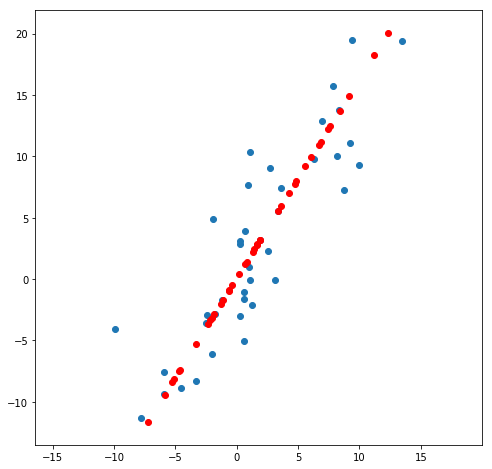

In [35]:
X = np.array(X)
Xmean = np.mean(X, axis=1)    # Mean of each dimension

_, _, P = pca(X, 1, method="EVD")    # P is the map to low-D subspace
Y, _, _ = pca(X, 1, method="SVD")    # Y is the cast on low-D subspace
Xhat = np.matmul(P, Y) + Xmean.T[:,np.newaxis]


# Plot
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(X[0], X[1])
_ = plt.scatter(Xhat[0], Xhat[1], color='red')

## 2. 在Yale人脸数据集上测试PCA

从[Yale Faces网站](http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html)上获取人脸数据。首先做如下预处理：

0. 下载时选取裁剪后图像，这样便免去手工对齐人脸；
1. 从每个人的人脸图像中选取相同光照条件的图片；
2. 压缩图片至原图$\frac{1}{2}$的尺寸。由于原图像尺寸为$192\times168$，维度过高，难以处理。

### 2.1 人脸图像缩放

In [44]:
# Scaling images DO NOT RUN AGAIN

from PIL import Image

PREFIX = "../databases/yaleFaces/"
FILENAME = "yaleB%s_P00A+005E-10.pgm"
imgIdx = ['0'+str(n) if n < 10 else str(n) for n in range(1,40)]
imgIdx.remove('14')

# Read faces as input
FHEIGHT = 192; FWIDTH = 168
X = []
for idx in imgIdx :
    img = Image.open(PREFIX + FILENAME%(idx))
    img = img.resize((FWIDTH//2, FHEIGHT//2))
    img.save(PREFIX+'resize/'+FILENAME%(idx))

testImg = Image.open(PREFIX+'resize/'+FILENAME%('01'))
#_ = plt.imshow(testImg)

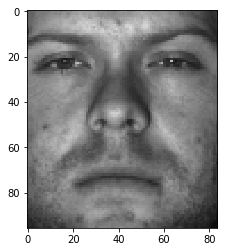

In [133]:
from PIL import Image

PREFIX = "../databases/yaleFaces/resize/"
FILENAME = "yaleB%s_P00A+005E-10.pgm"
imgIdx = ['0'+str(n) if n < 10 else str(n) for n in range(1,41)]
#custom faces at 14 & 40
#imgIdx.remove('14')

# Read faces as input
HEIGHT = 96; WIDTH = 84
X = []
for idx in imgIdx :
    img = Image.open(PREFIX + FILENAME%(idx))
    img = np.array(img)
    xi = img.reshape(HEIGHT*WIDTH, -1)
    X.append(xi)
X = np.concatenate(tuple(X), axis=1)
plt.imshow(X[:,0].reshape(HEIGHT,-1), cmap='gray', vmin=0, vmax=255)

# PCA
Y, Xhat, P = pca(X, 100, method="EVD")

### 2.2 使用低维数据重构人脸图像

将每一幅人脸图像视为一个高维数据点，对数据集内共38张人脸进行PCA。降维后对前5张人脸进行低维重建，维度分别取1、2、3、5、10、20：

1 dimensions


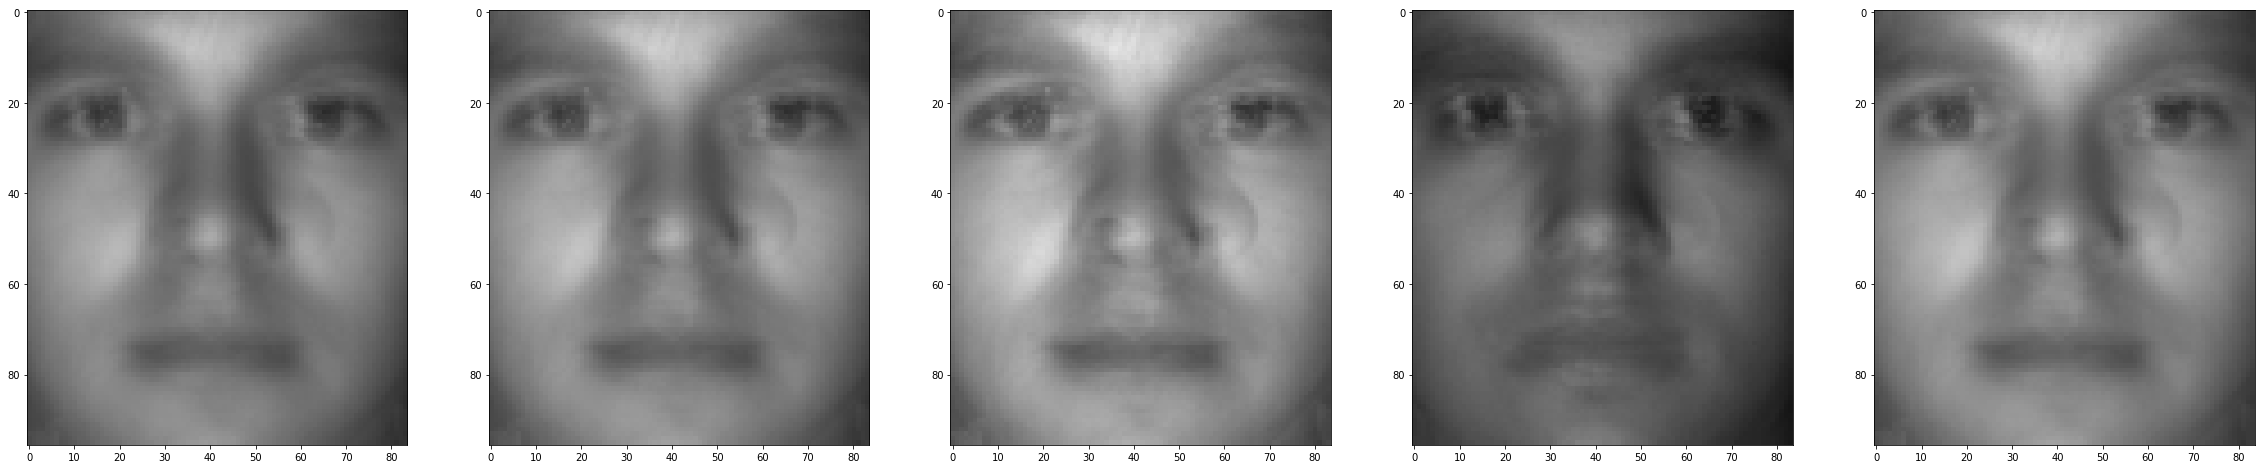

2 dimensions


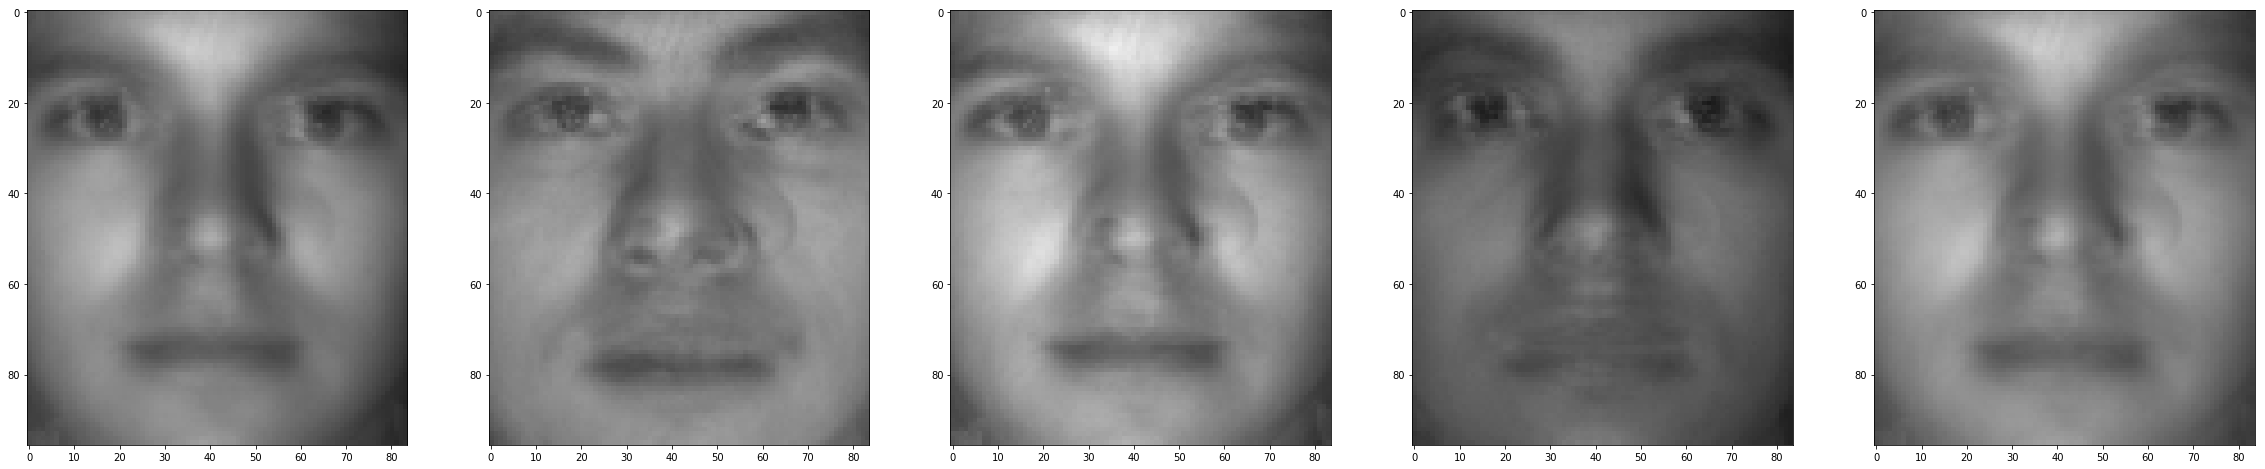

3 dimensions


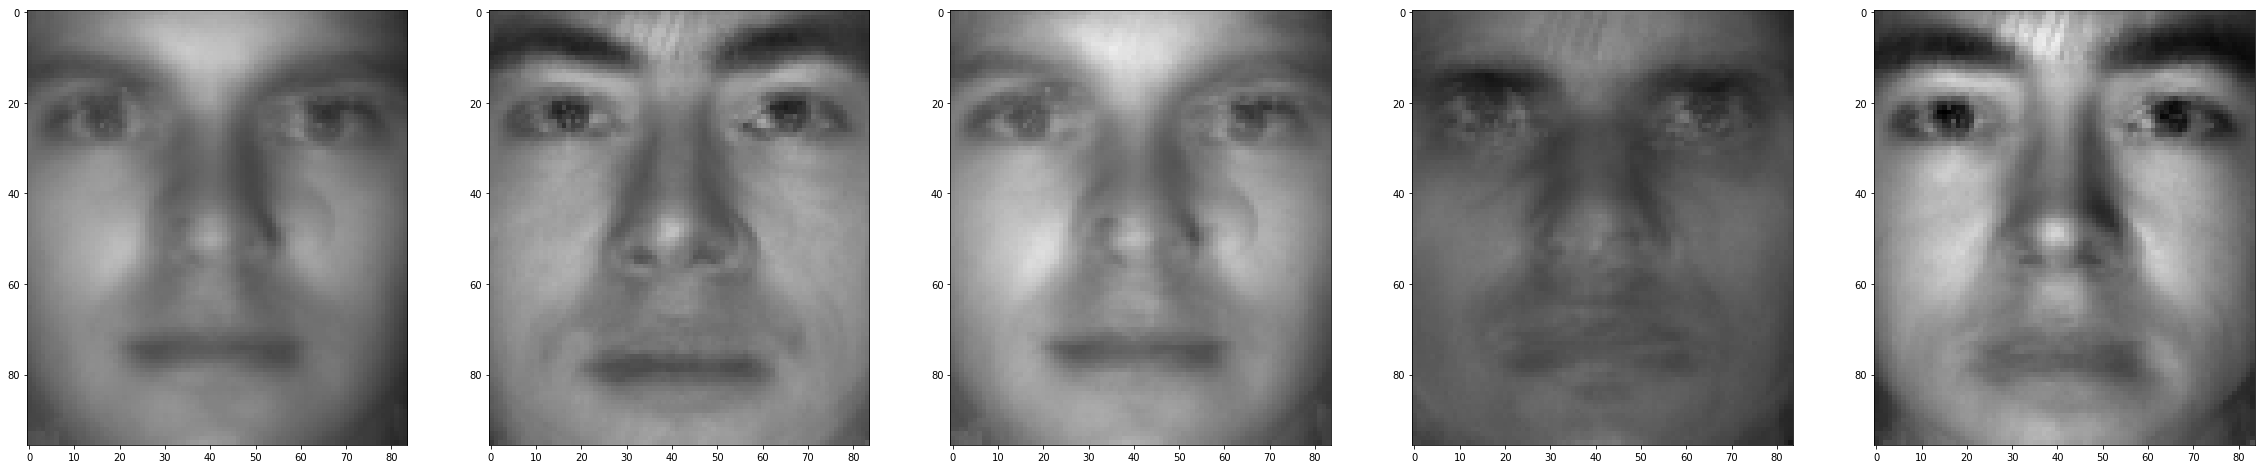

5 dimensions


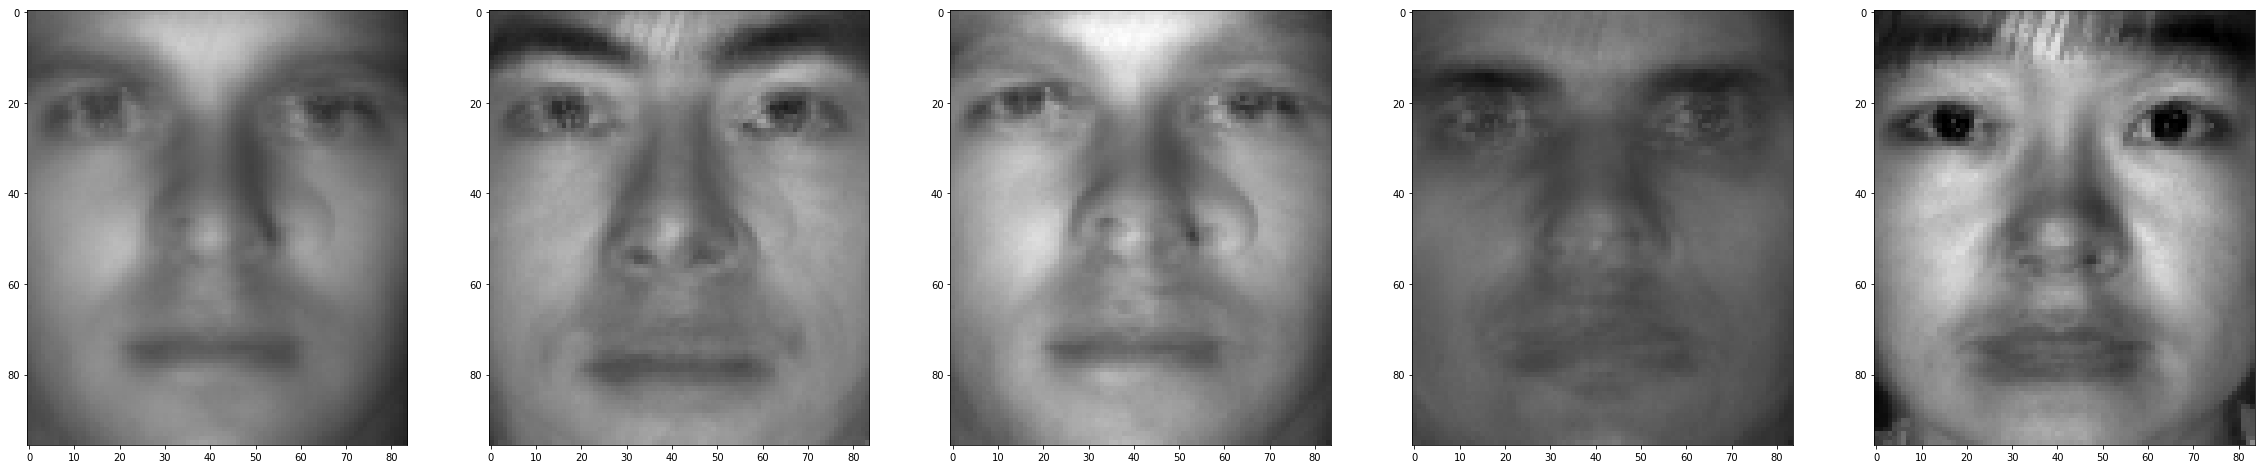

10 dimensions


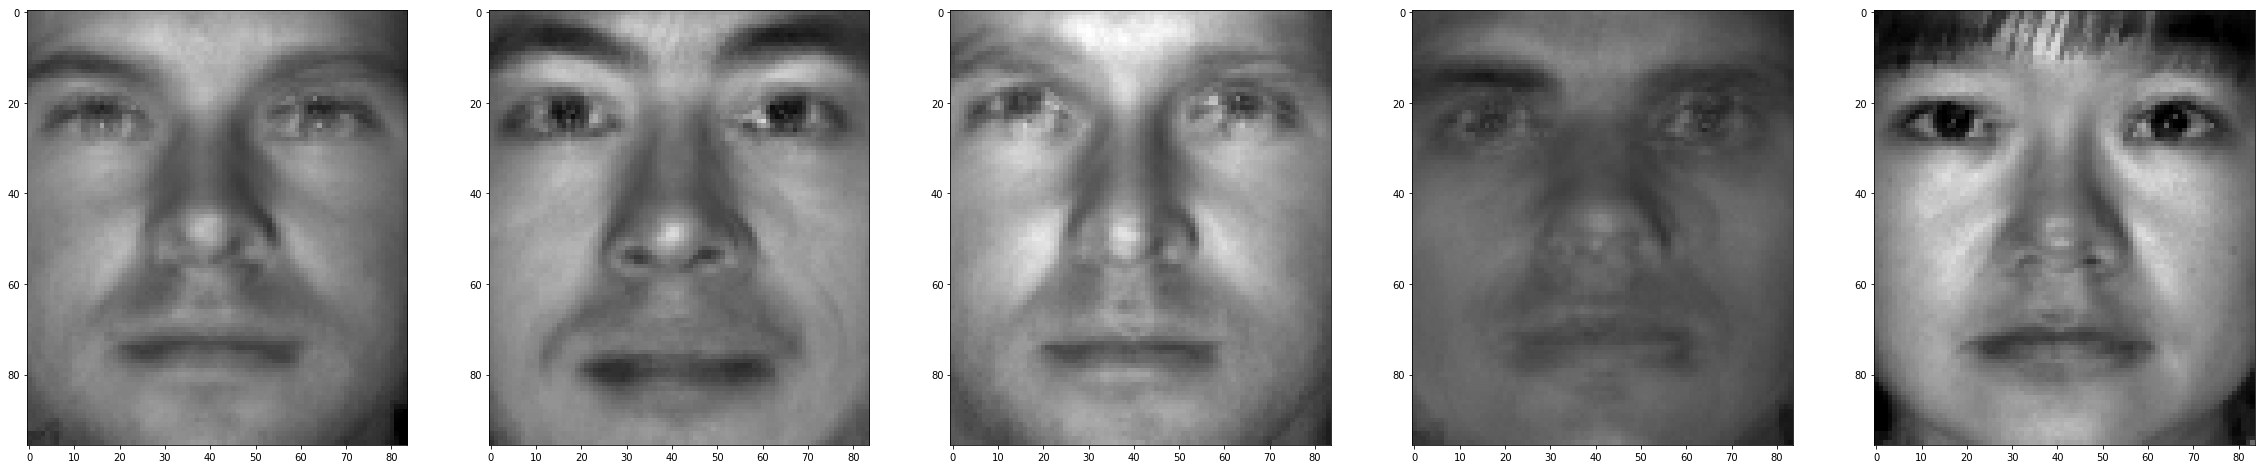

20 dimensions


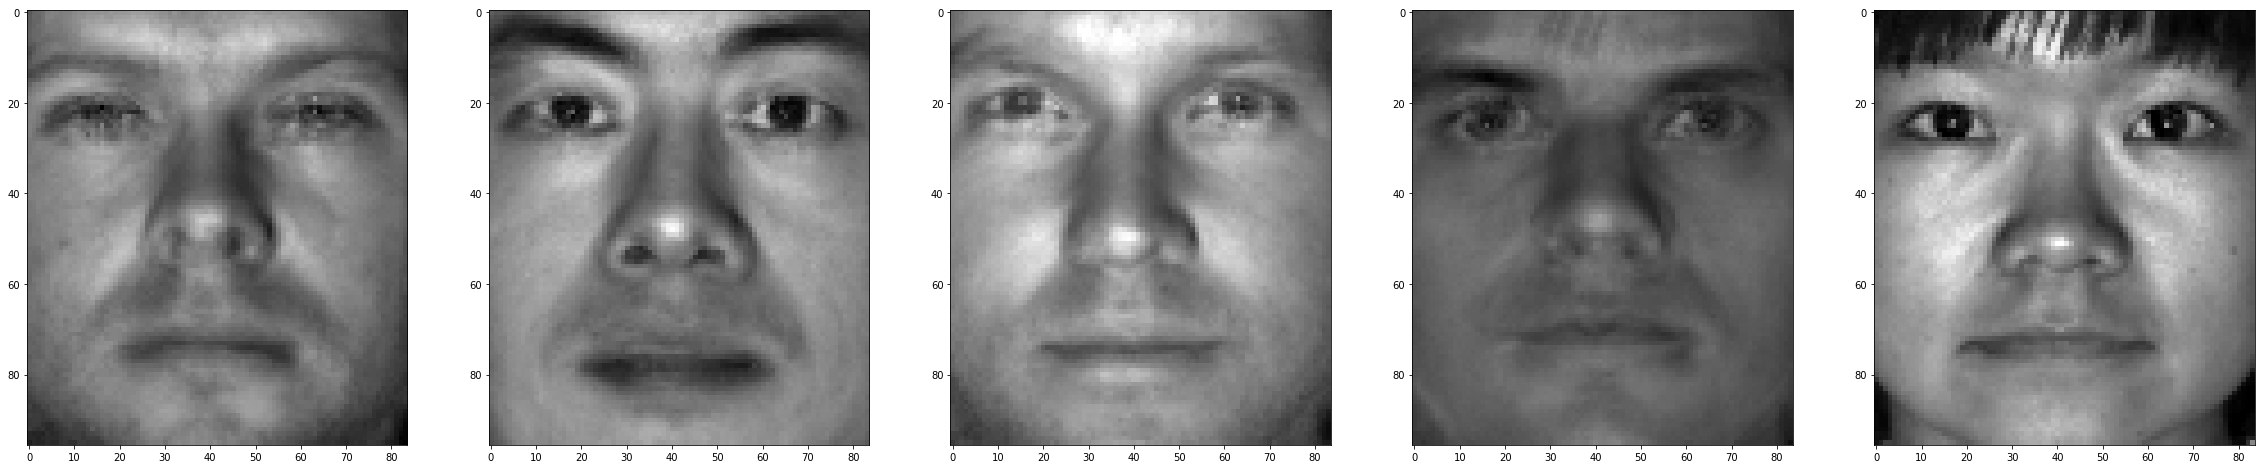

50 dimensions


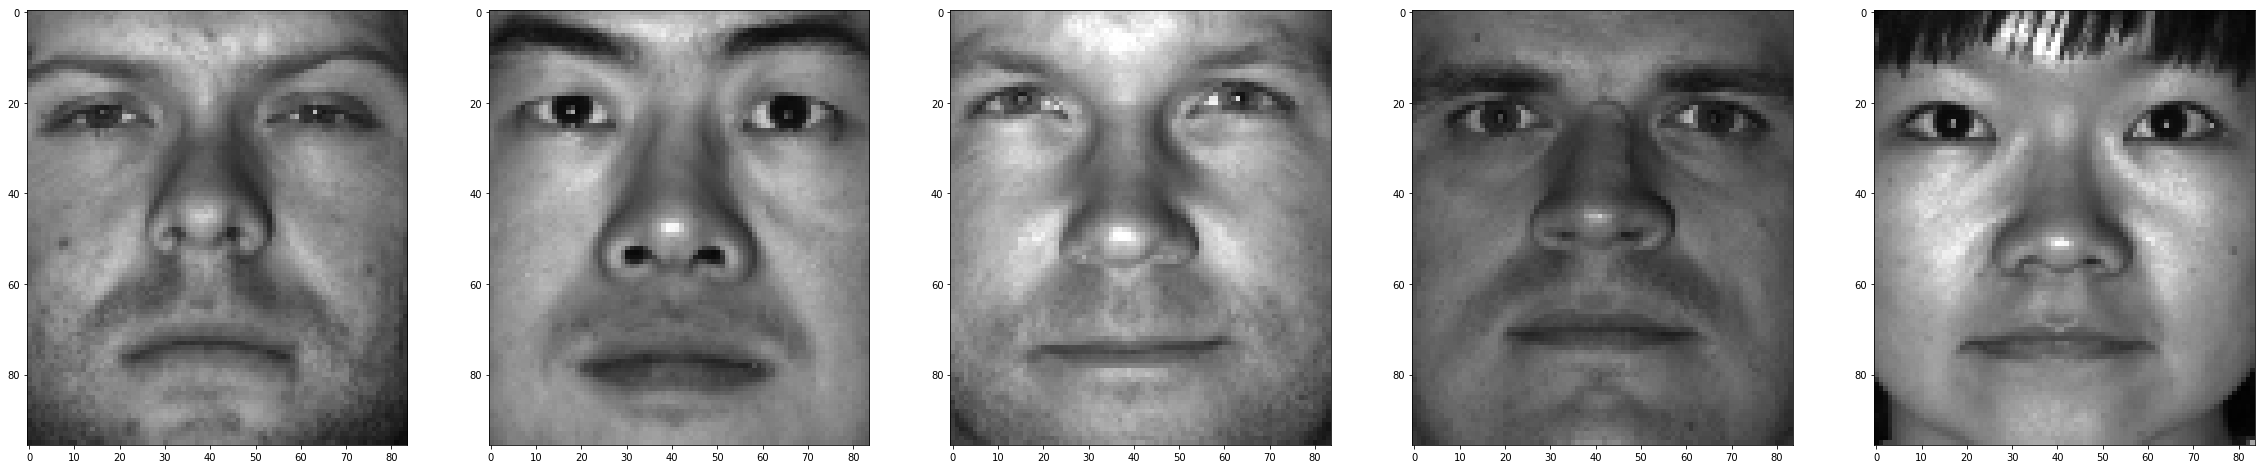

In [134]:
# A series of dimensions
ds = [1, 2, 3, 5, 10, 20, 50]
Xmean = np.mean(X, axis=1)
Xcen = X - Xmean.T[:,np.newaxis]
for d in ds :
    Xhat = np.matmul(P[:,:d], np.matmul(P[:,:d].T, Xcen)) + Xmean.T[:,np.newaxis]
    print(str(d), 'dimensions')
    plt.figure(figsize=(40,8))
    for i in range(5) :
        xhati = list(Xhat[:,i].T)
        xhati = [math.ceil(pix) for pix in xhati]
        xhati = np.array(xhati).reshape(HEIGHT,-1)
        plt.subplot(1,5,i+1)
        plt.imshow(xhati, cmap='gray', vmin=0, vmax=255)
    plt.pause(0.05)

发现在1维时与__“平均脸”__差别不大。随着维度的逐渐增高，人脸开始出现肤色、眉毛、头发等特征。从__20维__重建时，人脸与原本人脸的差别已经很小。人脸的降维有着重要的实际意义，人脸识别就是其中的典型应用。一个朴素的人脸识别算法可以直接使用人脸在低维子空间中的欧式距离作为标准评判人脸的相似程度。

### 2.3 使用自定义人脸

为了有趣起见，在Yale脸数据集中混入两张光线条件不同，且五官状态不标准（闭眼）的人脸数据。对这两张人脸的重建如下图所示，重建维度为1、2、5、10、20维。可见效果略逊于Yale脸。

若训练集中无此二人脸，但使用训练所得主方向（即“特征脸”）对该人脸进行降维，重建后所得人脸极为模糊。这说明这些人脸所求的的子空间并不具有普遍性，无法直接推广到其他人脸上。也说明__在特征维度远大于样本量时，PCA也存在着过拟合现象__。

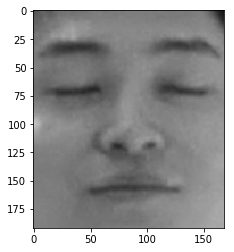

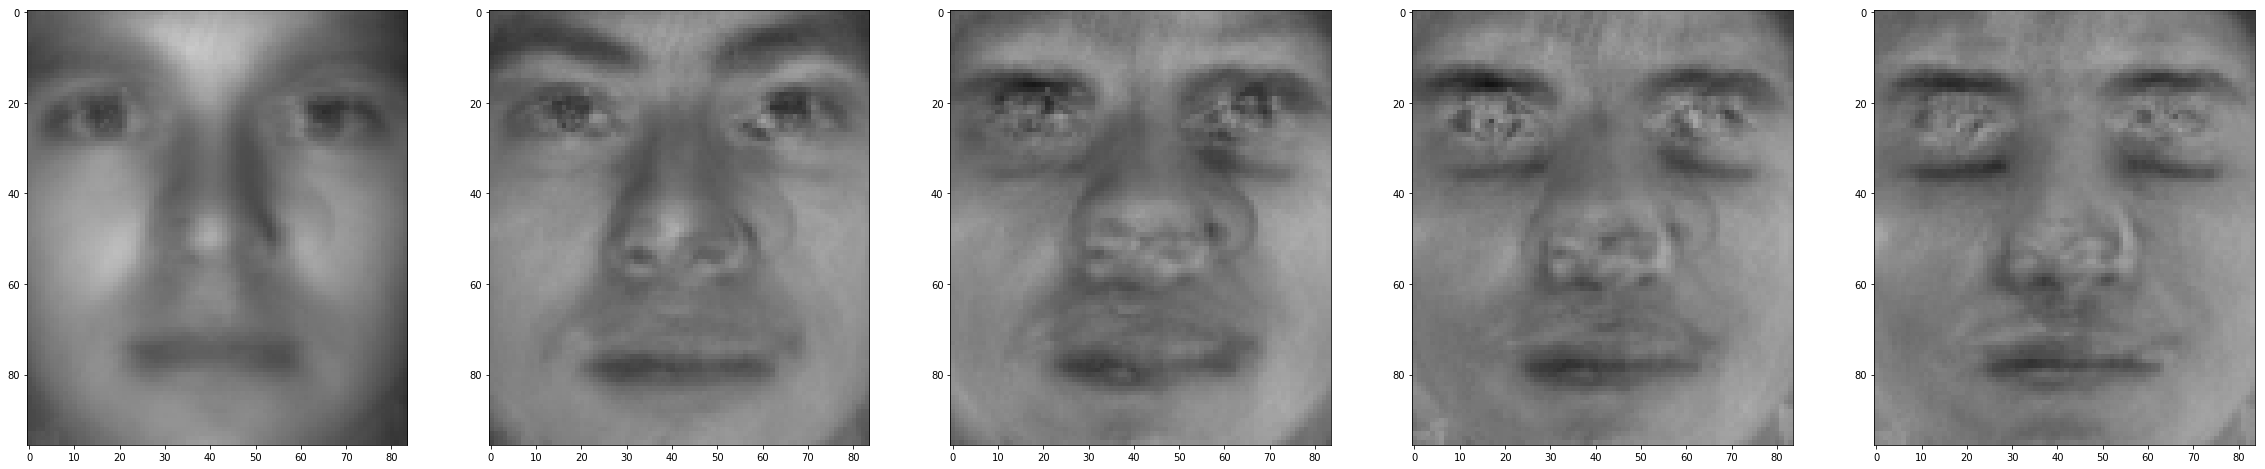

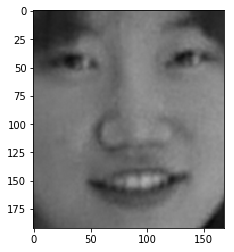

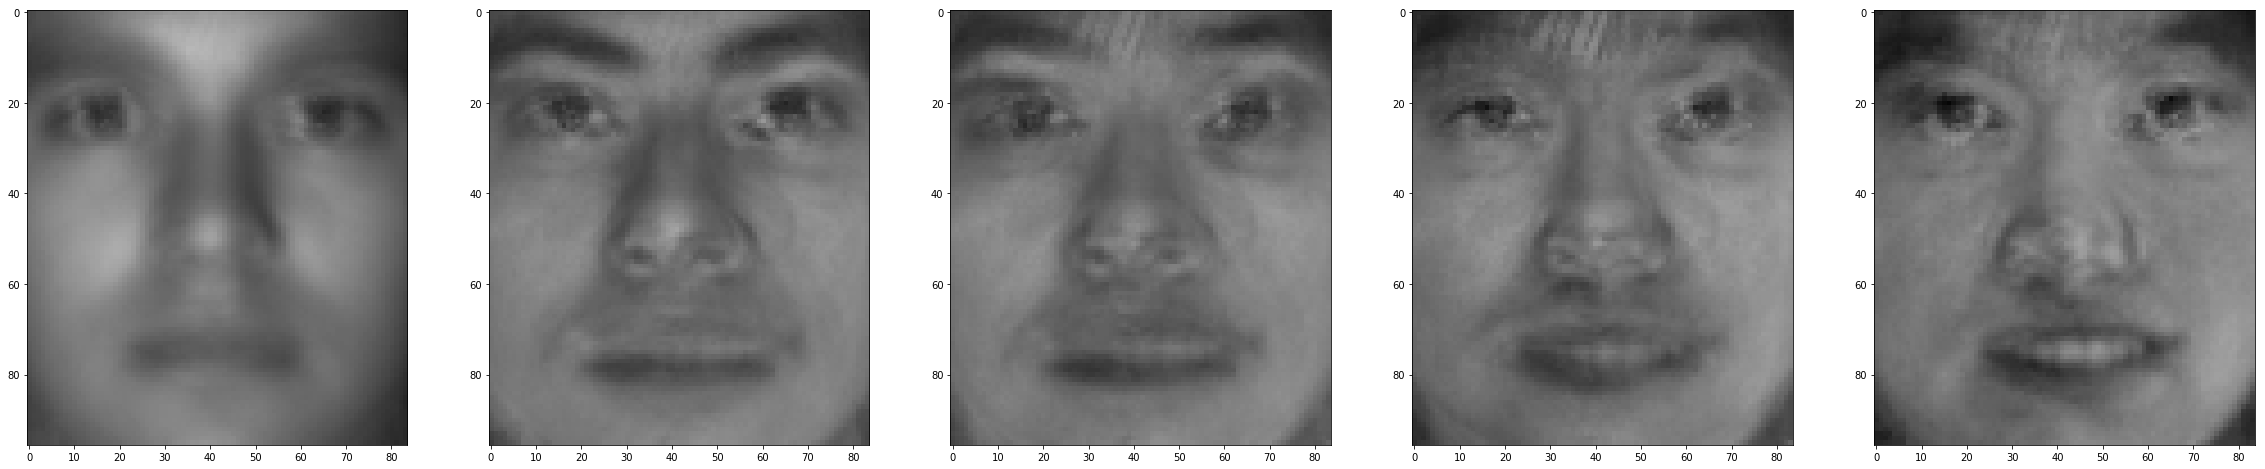

In [135]:
PREFIX = '../databases/faces/'
FILE_PATH = ['dmt.pgm', 'hjy.pgm']
FHEIGHT = 192; FWIDTH = 168

ds = [1, 2, 5, 10, 20]

for path in FILE_PATH :
    im = Image.open(PREFIX+path)
    plt.figure()
    plt.imshow(im, cmap='gray', vmin=0, vmax=255)

    im = im.resize((FWIDTH//2,FHEIGHT//2))
    im = np.array(im).reshape(-1,1)

    im = np.concatenate((X,im), axis=1)
    Xmean = np.mean(im, axis=1)
    Xcen = im - Xmean.T[:,np.newaxis]
    plt.figure(figsize=(40,8))
    for i,d in enumerate(ds) :
        Xhat = np.matmul(P[:,:d], np.matmul(P[:,:d].T, Xcen)) + Xmean.T[:,np.newaxis]
        cimg = Xhat[:,-1].reshape(HEIGHT,-1)
        plt.subplot(1,5,i+1)
        plt.imshow(cimg, cmap='gray', vmin=0, vmax=255)

### 2.5 特征脸

对于PCA中得到的子空间的基作图，即得到__“特征脸”__。上图展示出了前5个维度的“特征脸”。可以看出不同维度强调了人脸的不同特征。如眉毛在第2、3维度中较明显，而头发在第5维度中较明显。

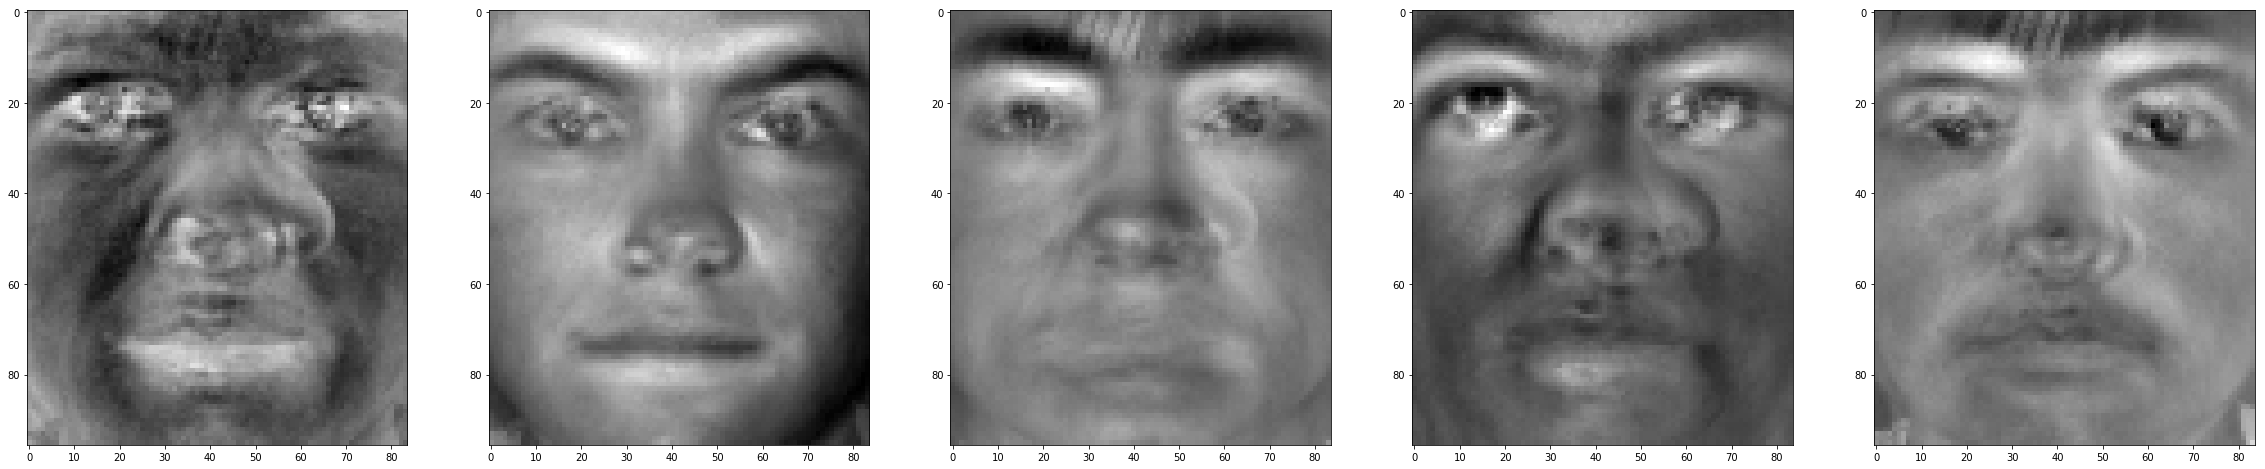

In [137]:
# Plot
plt.figure(figsize=(40,8))
for i in range(20) :    #plot eigen faces
    pi = list(P[:,i].T)
    pi = [ (pix-min(pi))/(max(pi)-min(pi))*256 for pix in pi ]
    pi = [math.floor(pix) for pix in pi]
    pi = np.array(pi).reshape(HEIGHT,-1)
    if i < 5 :
        plt.subplot(1,5,i+1)
        plt.imshow(pi, cmap='gray', vmin=0, vmax=255)
    imgTmp = Image.fromarray(np.uint8(pi))
    imgTmp.save('./eigenFaces/eigen_face_'+('0'+str(i) if i < 10 else str(i))+'.pgm')

### 2.6 使用PCA进行图像压缩

若将人脸图片的每行或每列作为数据点，而不是将整个图片作为数据点，则可实现不同的功能，即__图片压缩__。下图所示的图像将原图像压缩至__10维__得到：

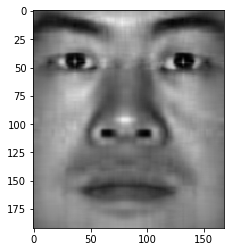

In [41]:
PREFIX = "../databases/yaleFaces/"
FILENAME = "yaleB%s_P00A+005E-10.pgm"

testImg = Image.open(PREFIX+'resize/'+FILENAME%('02'))
X = np.array(testImg)

# PCA
Y, Xhat, P = pca(X, 10, method="EVD")
_ = plt.imshow(Xhat, cmap='gray', vmin=0, vmax=255)